# Projet DA WildFires - Etude de la corrélation avec la sécheresse
__________________________________________________________________

> Par P. NGUYEN

## 0- Objectif de ce notebook

Dans ce notebook, nous allons étudier l'influence de la sécheresse sur la survenance et l'importance des feux de forêts aux Etats-Unis. Pour ce faire, nous allons utiliser dans un premier temps les données fournies pour l'US Drought Monitor, une initiative collaborative impliquant administrations et universités ayant pour objectif de suivre l'état de sécheresse du territoire américain :
> https://droughtmonitor.unl.edu/DmData/DataDownload/ComprehensiveStatistics.aspx

Des séries temporelles couvrant la période 2000 à 2016 peuvent ainsi être téléchargées sous diverses métriques et pour différentes unités de territoire. Nous choisissons d'étudier l'impact de la sécheresse sur les feux de forêt observés au Texas sur la même période. Pour décrire l'état de sécheresse, l'USDM utilise 5 indicateurs :
- Un premier niveau de sécheresse anormale (D0) associé aux terres sur le point d'entrer en sécheresse ou en fin de sécheresse
- Puis quatre niveaux de sécheresse supplémentaires : modéré (D1), sévère (D2), extrême (D3) et exceptionnelle (D4)

Puis nous intégrerons des données météorologiques fournies par la NOAA sous forme de Time Series mensuelles :
> https://www.ncdc.noaa.gov/cag/statewide/time-series

Nous nous intéresserons en particulier aux indicateurs suivants, pour l'état du Texas, sur la période 1992 à 2016 :
- La températeur moyenne
- Les précipitations moyennes
- L'indice PDSI

## 1- Chargement des librairies et des jeux de données initiaux

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as md
import datetime

%matplotlib inline
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

Chargement du jeu de données "Drought_TX" qui décrit les indicateurs de sécheresse du Texas de manière hebdomadaire pour la période 2000 à 2016 :

In [2]:
dr = pd.read_csv('drought_TX.csv', sep = ',')
dr.MapDate = pd.to_datetime(dr.MapDate, format = '%Y%m%d')
dr.drop(['StateAbbreviation', 'StatisticFormatID', 'ValidStart', 'ValidEnd'], axis = 1, inplace = True)
dr = dr.set_index(['MapDate'])
dr.sort_values(by = ['MapDate'], inplace = True)
dr

,None,D0,D1,D2,D3,D4
MapDate,,,,,,
2000-01-04,2.56,23.71,22.18,51.55,0.0,0.0
2000-01-11,0.17,24.98,23.29,51.56,0.0,0.0
2000-01-18,0.00,25.15,23.29,51.56,0.0,0.0
2000-01-25,0.00,25.15,23.29,51.56,0.0,0.0
2000-02-01,0.00,18.39,25.48,56.13,0.0,0.0
...,...,...,...,...,...,...
2016-05-03,89.33,9.59,1.08,0.00,0.0,0.0
2016-05-10,90.05,9.21,0.73,0.00,0.0,0.0
2016-05-17,97.40,2.51,0.09,0.00,0.0,0.0


> **Signification des indicateurs :**<br>
>- **None :** Aucune sécheresse<br>
>- **D0 :** Sécheresse anormale<br>
>- **D1 :** Sécheresse modérée<br>
>- **D2 :** Sécheresse sévère<br>
>- **D3 :** Sécheresse extrême<br>
>- **D4 :** Sécheresse exceptionnelle

In [3]:
dr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 857 entries, 2000-01-04 to 2016-05-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   None    857 non-null    float64
 1   D0      857 non-null    float64
 2   D1      857 non-null    float64
 3   D2      857 non-null    float64
 4   D3      857 non-null    float64
 5   D4      857 non-null    float64
dtypes: float64(6)
memory usage: 46.9 KB


Chargement du jeu de données "Wildfires" filtré sur l'état du Texas :

In [3]:
df = pd.read_csv('Fires_filter.csv', index_col = 'OBJECTID')
df.DISCOVERY_DATE = pd.to_datetime(df.DISCOVERY_DATE)
df.CONT_DATE = pd.to_datetime(df.CONT_DATE)
df = df.query('STATE == "TX"')
df

,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
OBJECTID,,,,,,,,,,,,,,,,,,
284,LAKE FANNIN,2005,2005-01-24,24,1000.0,7.0,Arson,2005-01-24,24.0,1500.0,3.00,B,33.786111,-96.150000,TX,NaN,NaN,NaN
285,CEMETERY,2005,2005-01-25,25,1830.0,5.0,Debris Burning,2005-01-25,25.0,2222.0,55.00,C,31.312500,-94.270833,TX,NaN,NaN,NaN
286,BLACK CREEK,2005,2005-03-12,71,215.0,4.0,Campfire,2005-03-13,72.0,1800.0,2.00,B,33.345833,-97.595833,TX,NaN,NaN,NaN
287,WELL DAM,2005,2005-04-03,93,1730.0,3.0,Smoking,2005-04-03,93.0,1840.0,0.30,B,31.386667,-95.150556,TX,NaN,NaN,NaN
288,ENON CEMETARY,2005,2005-04-07,97,1800.0,1.0,Lightning,2005-04-08,98.0,1550.0,55.00,C,31.354167,-95.085278,TX,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856361,COMANCHE,2015,2015-10-19,292,NaN,13.0,Missing/Undefined,2015-10-19,292.0,1820.0,49.70,C,31.031333,-97.618000,TX,Bell,27.0,Bell
1856400,6300,2015,2015-10-21,294,1948.0,13.0,Missing/Undefined,2015-10-21,294.0,2217.0,1.00,B,32.846100,-94.967600,TX,Upshur,459.0,Upshur
1856440,HOUSE,2015,2015-10-28,301,1150.0,13.0,Missing/Undefined,2015-10-28,301.0,1255.0,0.25,A,33.164283,-96.252667,TX,Hunt,231.0,Hunt


## 2- Visualisation autour du jeu de données "Indicateurs de sécheresse"

Le jeu de données décrivant les indicateurs de sécheresse du Texas décrit de manière hebdomadaire (1 ligne = 1 semaine) les pourcentages du territoire ayant atteint les 5 niveaux de sécheresse évoqués précédemmment :

In [5]:
dr

,None,D0,D1,D2,D3,D4
MapDate,,,,,,
2000-01-04,2.56,23.71,22.18,51.55,0.0,0.0
2000-01-11,0.17,24.98,23.29,51.56,0.0,0.0
2000-01-18,0.00,25.15,23.29,51.56,0.0,0.0
2000-01-25,0.00,25.15,23.29,51.56,0.0,0.0
2000-02-01,0.00,18.39,25.48,56.13,0.0,0.0
...,...,...,...,...,...,...
2016-05-03,89.33,9.59,1.08,0.00,0.0,0.0
2016-05-10,90.05,9.21,0.73,0.00,0.0,0.0
2016-05-17,97.40,2.51,0.09,0.00,0.0,0.0


> *Le 04/01/2000 : **51.55%** du territoire texan était en sécheresse dite D2, **22.18%** en sécheresse dite D1, **23.71%** en sécheresse dite D0 et seulement **2.56%** n'était pas en sécheresse*

Nous décidons de ne pas faire de distinction dans le niveau de sécheresse et consolidons le pourcentage global de l'état texan en proie à la sécheresse en sommant les différents ratios :

In [4]:
dr['D_cumsum'] = dr['D0'] + dr['D1'] + dr['D2'] + dr['D3'] + dr['D4']

Traçons maintenant l'évolution de ce nouvel indicateur représentant le pourcentage cumulé/global du territoire texan en sécheresse et mettons en avant une courbe de tendance pour plus de lisibilité :

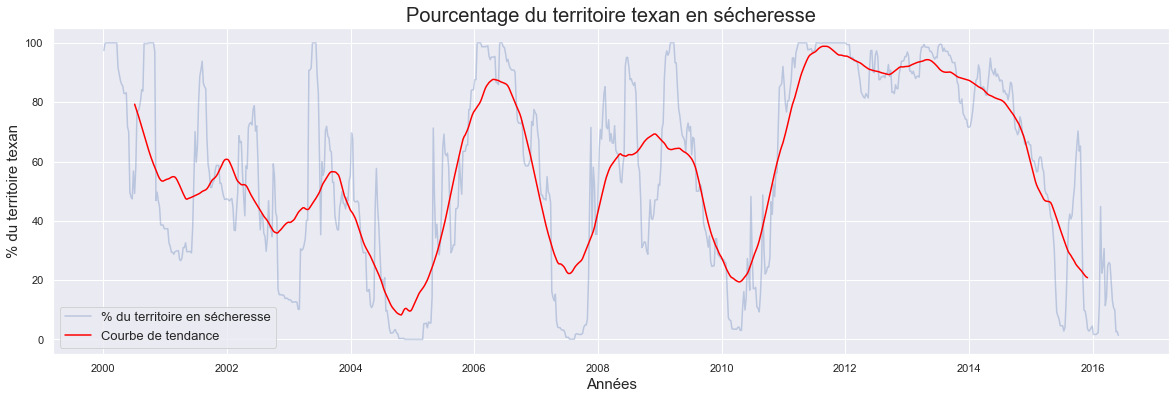

In [13]:
fig, axs = plt.subplots(nrows = 1, figsize = (20, 6))
sns.lineplot(x = dr.index, y = dr.D_cumsum, ls = '-', alpha = 0.3, ax = axs, label = '% du territoire en sécheresse')
decomposition = sm.tsa.seasonal_decompose(dr.loc[:, 'D_cumsum'], model = 'additive')
sns.lineplot(x = decomposition.trend.index, y = decomposition.trend, ls = '-', color = 'red', ax = axs, label = 'Courbe de tendance')
axs.set_xlabel("Années",fontsize=15)
axs.set_ylabel("% du territoire texan",fontsize=15)
plt.title('Pourcentage du territoire texan en sécheresse', fontsize = 20)
plt.legend(loc = 'best', fontsize = 13);

## 3- Rapprochement entre sécheresse et nombre de feux au Texas

Les données de sécheresse issus du site "droughtmonitor" ne démarrant qu'à partir de 2000 :
- Filtrons les données Wildfires pour un démarrage à partir de cette année
- Agrégeons les données par date afin de comptabliser le nombre journalier de feux au Texas

In [9]:
df_count = df[df['DISCOVERY_DATE'] >= '2000-01-01'].groupby('DISCOVERY_DATE').agg({'FIRE_SIZE_CLASS':'count'})
df_count.rename({'FIRE_SIZE_CLASS':'Daily_count'}, axis = 1, inplace = True)
df_count = df_count.asfreq('w')
df_count.fillna(method = 'ffill', inplace = True)
df_count

,Daily_count
DISCOVERY_DATE,
2000-01-02,15.0
2000-01-09,5.0
2000-01-16,11.0
2000-01-23,8.0
2000-01-30,5.0
...,...
2015-11-29,1.0
2015-12-06,11.0
2015-12-13,3.0


Superposons sur un même graphique la courbe décrivant le nombre de feux recensés quotidiennement au Texas et la courbe de tendance qualifiant le % du territoire texan en sécheresse :

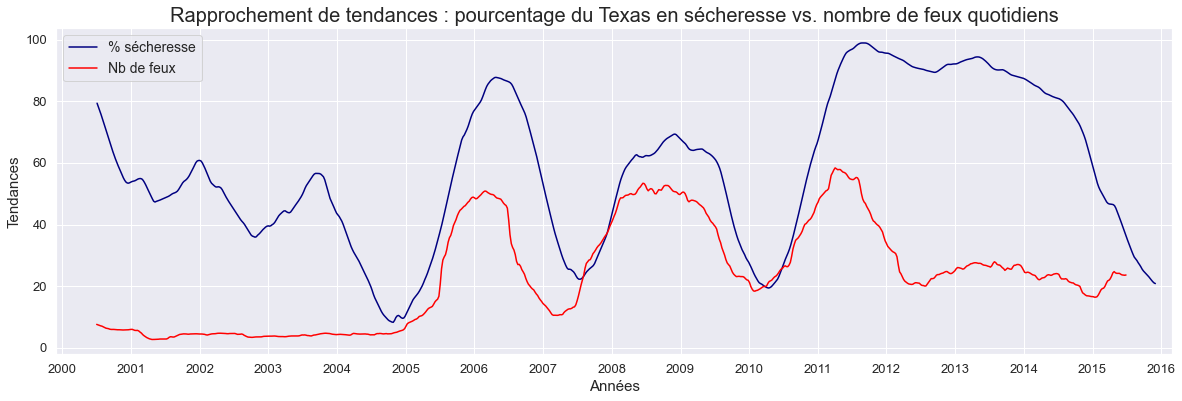

In [10]:
fig, axs = plt.subplots(nrows = 1, figsize = (20, 6))
decomposition = sm.tsa.seasonal_decompose(dr.loc[:, 'D_cumsum'], model = 'additive')
sns.lineplot(x = decomposition.trend.index, y = decomposition.trend, ls = '-', color = 'navy', ax = axs, label = '% sécheresse')
decomposition = sm.tsa.seasonal_decompose(df_count.loc[:,'Daily_count'], model = 'additive')
sns.lineplot(x = decomposition.trend.index, y = decomposition.trend, ls = '-', color = 'red', ax = axs, label = 'Nb de feux')
axs.set_xlabel("Années",fontsize=15)
axs.set_ylabel("Tendances",fontsize=15)
axs.xaxis.set_major_locator(md.YearLocator())
axs.xaxis.set_major_formatter(md.DateFormatter('%Y'))
axs.set_xlim([datetime.date(1999, 12, 1), datetime.date(2016, 3, 1)])
axs.tick_params(labelsize=13)
plt.legend(loc = 'upper left', prop={'size': 14})
plt.title('Rapprochement de tendances : pourcentage du Texas en sécheresse vs. nombre de feux quotidiens', fontsize = 20);

> **Conclusion n°1 :** la superposition des 2 courbes laisse à penser qu'il y a un lien de corrélation entre % du territoire texan en sécheresse et nombre de feux recensés, cela peut paraître évident mais essayons d'être plus précis.

## 4- Etude de la corrélation entre sécheresse et feux de forêt au Texas

A l'instar du décompte de feux journaliers, enrichissons notre jeu de données avec un indicateur décrivant la surface totale du territoire texan brûlée de manière journalière :

In [11]:
df_sum = df[df['DISCOVERY_DATE'] >= '2000-01-01'].groupby('DISCOVERY_DATE').agg({'FIRE_SIZE':'sum'})
df_sum.rename({'FIRE_SIZE':'Surface'}, axis = 1, inplace = True)
df_sum =  df_sum.asfreq('d')
df_sum.fillna(method = 'ffill', inplace = True)
df_sum

,Surface
DISCOVERY_DATE,
2000-01-01,2208.50
2000-01-02,316.00
2000-01-03,952.20
2000-01-04,682.00
2000-01-05,295.00
...,...
2015-12-27,535.25
2015-12-28,1.00
2015-12-29,0.11


Afin de faciliter les jointures de jeux de données à venir, échantillonnons le jeu de données "df_count" à la journée en remplissant les données manquantes via la méthode "ffill" :

In [12]:
df_count =  df_count.asfreq('d')
df_count.fillna(method = 'ffill', inplace = True)
df_count

,Daily_count
DISCOVERY_DATE,
2000-01-02,15.0
2000-01-03,15.0
2000-01-04,15.0
2000-01-05,15.0
2000-01-06,15.0
...,...
2015-12-23,8.0
2015-12-24,8.0
2015-12-25,8.0


Opérons la jointure entre les 3 jeux de données décrivant (1) le % du territoire texan en sécheresse, (2) le nombre de feux journaliers et (3) la surface journalière des incendies :

In [13]:
df_cible = dr[['D_cumsum']].join(df_count)
df_cible = df_cible.join(df_sum)
df_cible.dropna(how = 'any', inplace = True)
df_cible

,D_cumsum,Daily_count,Surface
MapDate,,,
2000-01-04,97.44,15.0,682.00
2000-01-11,99.83,5.0,137.00
2000-01-18,100.00,11.0,64.00
2000-01-25,100.00,8.0,110.00
2000-02-01,100.00,5.0,28.00
...,...,...,...
2015-11-24,7.35,7.0,232.85
2015-12-01,3.62,1.0,0.85
2015-12-08,2.83,11.0,90.50


Calculons le coefficient de corrélation entre ces 3 variables :

In [14]:
df_cible.corr()

,D_cumsum,Daily_count,Surface
D_cumsum,1.000000,0.362058,0.158694
Daily_count,0.362058,1.000000,0.223697
Surface,0.158694,0.223697,1.000000


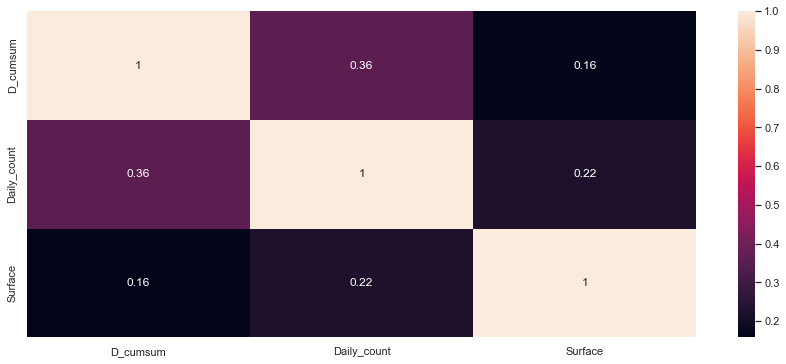

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(df_cible.corr(), annot = True, cmap = 'rocket');

> **Conclusion n°2 :** Finalement l'influence du % de terres en sécheresse sur le nombre de feux recensés (0.36) est limité et il n'a pas d'effet notable sur les surfaces brûlées (0.16)

## 5- Etude de l'influence d'autres indicateurs météorologiques

La NOAA fournit différents indicateurs météorologiques sous forme de séries temporelles échantillonnées au mois, intéressons-nous sur la période du jeu de données Wildfires (1992 - 2016) :

> 1. A la température moyenne

In [15]:
tx_tavg = pd.read_csv('TX-tavg-1992-2016.csv')
tx_tavg['Date'] = pd.to_datetime(tx_tavg['Date'], format = '%Y%m')
tx_tavg.set_index('Date', inplace = True)
tx_tavg

,Average Temperature,Anomaly
Date,,
1992-01-01,45.4,0.0
1992-02-01,53.0,3.6
1992-03-01,58.9,2.6
1992-04-01,64.5,-0.3
1992-05-01,69.6,-2.9
...,...,...
2015-09-01,79.2,3.3
2015-10-01,69.2,3.1
2015-11-01,57.3,2.7


In [16]:
tx_tavg.rename({'Anomaly':'Temp_Anomaly'}, axis = 1, inplace = True)
tx_tavg

,Average Temperature,Temp_Anomaly
Date,,
1992-01-01,45.4,0.0
1992-02-01,53.0,3.6
1992-03-01,58.9,2.6
1992-04-01,64.5,-0.3
1992-05-01,69.6,-2.9
...,...,...
2015-09-01,79.2,3.3
2015-10-01,69.2,3.1
2015-11-01,57.3,2.7


> 2. Aux précipitations moyennes

In [17]:
tx_pcp = pd.read_csv('TX-pcp-1992-2016.csv')
tx_pcp['Date'] = pd.to_datetime(tx_pcp['Date'], format = '%Y%m')
tx_pcp.set_index('Date', inplace = True)
tx_pcp

,Precipitation,Anomaly
Date,,
1992-01-01,3.15,1.66
1992-02-01,3.98,2.38
1992-03-01,2.24,0.58
1992-04-01,2.31,-0.05
1992-05-01,5.09,1.72
...,...,...
2015-09-01,1.43,-1.50
2015-10-01,6.17,3.64
2015-11-01,3.87,2.01


In [19]:
tx_pcp.rename({'Anomaly':'PCP_Anomaly'}, axis = 1, inplace = True)
tx_pcp

,Precipitation,PCP_Anomaly
Date,,
1992-01-01,3.15,1.66
1992-02-01,3.98,2.38
1992-03-01,2.24,0.58
1992-04-01,2.31,-0.05
1992-05-01,5.09,1.72
...,...,...
2015-09-01,1.43,-1.50
2015-10-01,6.17,3.64
2015-11-01,3.87,2.01


> 3. A l'indice de sécheresse de Palmer

In [20]:
tx_pdsi = pd.read_csv('TX-pdsi-1992-2016.csv')
tx_pdsi['Date'] = pd.to_datetime(tx_pdsi['Date'], format = '%Y%m')
tx_pdsi.set_index('Date', inplace = True)
tx_pdsi

,PDSI,Anomaly
Date,,
1992-01-01,4.68,4.83
1992-02-01,5.53,5.65
1992-03-01,5.25,5.25
1992-04-01,4.93,4.87
1992-05-01,5.55,5.51
...,...,...
2015-09-01,2.82,2.98
2015-10-01,3.86,3.89
2015-11-01,4.64,4.67


In [21]:
tx_pdsi.rename({'Anomaly':'PDSI_Anomaly'}, axis = 1, inplace = True)
tx_pdsi

,PDSI,PDSI_Anomaly
Date,,
1992-01-01,4.68,4.83
1992-02-01,5.53,5.65
1992-03-01,5.25,5.25
1992-04-01,4.93,4.87
1992-05-01,5.55,5.51
...,...,...
2015-09-01,2.82,2.98
2015-10-01,3.86,3.89
2015-11-01,4.64,4.67


Opérons le merge des 3 jeux de données:

In [22]:
df_gsom = pd.merge(tx_tavg, tx_pcp, left_index = True, right_index = True)
df_gsom = pd.merge(df_gsom, tx_pdsi, left_index = True, right_index = True)
df_gsom

,Average Temperature,Temp_Anomaly,Precipitation,PCP_Anomaly,PDSI,PDSI_Anomaly
Date,,,,,,
1992-01-01,45.4,0.0,3.15,1.66,4.68,4.83
1992-02-01,53.0,3.6,3.98,2.38,5.53,5.65
1992-03-01,58.9,2.6,2.24,0.58,5.25,5.25
1992-04-01,64.5,-0.3,2.31,-0.05,4.93,4.87
1992-05-01,69.6,-2.9,5.09,1.72,5.55,5.51
...,...,...,...,...,...,...
2015-09-01,79.2,3.3,1.43,-1.50,2.82,2.98
2015-10-01,69.2,3.1,6.17,3.64,3.86,3.89
2015-11-01,57.3,2.7,3.87,2.01,4.64,4.67


Appliquons un groupby sur le jeu de données Wildfires afin d'agréger le nombre de feux recensés et la surface totale des incendies :

In [23]:
df_gpby = df.groupby('DISCOVERY_DATE').agg({'FIRE_SIZE_CLASS':'count', 'FIRE_SIZE': 'sum'})
df_gpby.rename({'FIRE_SIZE_CLASS':'Monthly_count', 'FIRE_SIZE':'Monthly_surface'}, axis = 1, inplace = True)
df_gpby

,Monthly_count,Monthly_surface
DISCOVERY_DATE,,
1992-01-01,3,38.00
1992-01-06,1,3.00
1992-01-07,1,5.00
1992-01-10,2,85.00
1992-01-11,1,20.00
...,...,...
2015-12-26,10,535.25
2015-12-28,1,1.00
2015-12-29,2,0.11


Rééchantillonnons le "df_gpby" au mois en démarrant chaque entrée au 1er du mois :

In [24]:
df_gpby = df_gpby.resample('MS').sum()
df_gpby

,Monthly_count,Monthly_surface
DISCOVERY_DATE,,
1992-01-01,48,712.00
1992-02-01,110,2096.00
1992-03-01,103,1631.80
1992-04-01,37,950.70
1992-05-01,28,301.40
...,...,...
2015-08-01,1594,90159.87
2015-09-01,1256,31610.19
2015-10-01,1349,29518.76


Faisons le merge entre les 2 jeux de données :

In [26]:
df_gpby = pd.merge(df_gpby, df_gsom, left_index = True, right_index = True)
df_gpby

,Monthly_count,Monthly_surface,Average Temperature,Temp_Anomaly,Precipitation,PCP_Anomaly,PDSI,PDSI_Anomaly
1992-01-01,48,712.00,45.4,0.0,3.15,1.66,4.68,4.83
1992-02-01,110,2096.00,53.0,3.6,3.98,2.38,5.53,5.65
1992-03-01,103,1631.80,58.9,2.6,2.24,0.58,5.25,5.25
1992-04-01,37,950.70,64.5,-0.3,2.31,-0.05,4.93,4.87
1992-05-01,28,301.40,69.6,-2.9,5.09,1.72,5.55,5.51
...,...,...,...,...,...,...,...,...
2015-08-01,1594,90159.87,83.3,1.4,1.43,-0.88,4.19,4.22
2015-09-01,1256,31610.19,79.2,3.3,1.43,-1.50,2.82,2.98
2015-10-01,1349,29518.76,69.2,3.1,6.17,3.64,3.86,3.89
2015-11-01,182,5876.36,57.3,2.7,3.87,2.01,4.64,4.67


Gardons les variables réellement significatives pour cette étude, à savoir : l'anomalie de températeur, la précipitation moyenne et l'index de Palmer :

In [27]:
df_gpby.drop(['PDSI_Anomaly', 'Average Temperature', 'PCP_Anomaly'], axis = 1, inplace = True)
df_gpby

,Monthly_count,Monthly_surface,Temp_Anomaly,Precipitation,PDSI
1992-01-01,48,712.00,0.0,3.15,4.68
1992-02-01,110,2096.00,3.6,3.98,5.53
1992-03-01,103,1631.80,2.6,2.24,5.25
1992-04-01,37,950.70,-0.3,2.31,4.93
1992-05-01,28,301.40,-2.9,5.09,5.55
...,...,...,...,...,...
2015-08-01,1594,90159.87,1.4,1.43,4.19
2015-09-01,1256,31610.19,3.3,1.43,2.82
2015-10-01,1349,29518.76,3.1,6.17,3.86
2015-11-01,182,5876.36,2.7,3.87,4.64


In [28]:
df_gpby.describe()

,Monthly_count,Monthly_surface,Temp_Anomaly,Precipitation,PDSI
count,288.000000,2.880000e+02,288.000000,288.000000,288.000000
mean,493.128472,3.397992e+04,0.999653,2.332222,-0.281354
std,611.691544,1.311441e+05,2.394775,1.348382,3.177354
min,1.000000,3.520000e+01,-5.400000,0.230000,-8.060000
25%,77.750000,1.921475e+03,-0.700000,1.325000,-2.950000
50%,233.000000,5.552925e+03,0.900000,2.160000,-0.545000
75%,705.500000,1.877810e+04,2.500000,3.010000,2.147500
max,3612.000000,1.692467e+06,7.600000,9.050000,7.700000


Affichons le coefficient de corrélation entre les différentes variables :

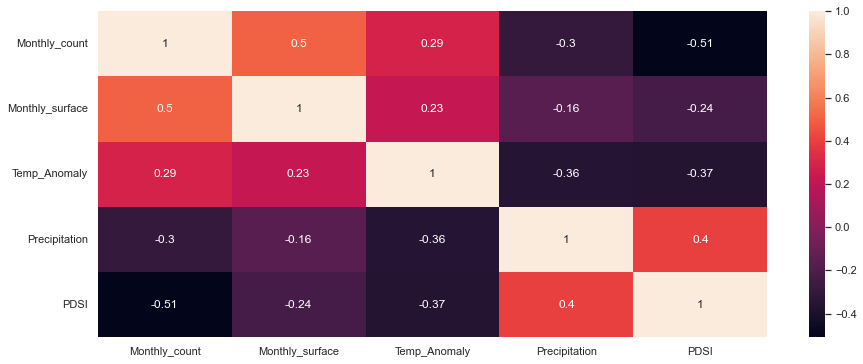

In [27]:
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(df_gpby.corr(), annot = True, cmap = 'rocket');

> **Conclusion n°3 :** L'index de sécheresse de Palmer présente un coefficient de corrélation modéré avec l'indicateur décomptant le nombre de feux recensés au mois mais ce coefficient est le plus important qu'on ait recensé et surtout, il est plus significatif que le pourcentage de terres en sécheresse étudié précédemment. Les indicateurs de nombre et de surface des feux sont peu corrélés avec les indicateurs de température et de précipitations.

## 6- Visualisation de la corrélation entre l'index de sécheresse de Palmer et le nombre de feux

Préparons le jeu de données pour faciliter la visualisation :

In [29]:
df_gpby.reset_index(inplace = True)
df_gpby

,index,Monthly_count,Monthly_surface,Temp_Anomaly,Precipitation,PDSI
0,1992-01-01,48,712.00,0.0,3.15,4.68
1,1992-02-01,110,2096.00,3.6,3.98,5.53
2,1992-03-01,103,1631.80,2.6,2.24,5.25
3,1992-04-01,37,950.70,-0.3,2.31,4.93
4,1992-05-01,28,301.40,-2.9,5.09,5.55
...,...,...,...,...,...,...
283,2015-08-01,1594,90159.87,1.4,1.43,4.19
284,2015-09-01,1256,31610.19,3.3,1.43,2.82
285,2015-10-01,1349,29518.76,3.1,6.17,3.86
286,2015-11-01,182,5876.36,2.7,3.87,4.64


In [30]:
df_gpby['Year'] = df_gpby['index'].apply(lambda x: x.year)
df_gpby

,index,Monthly_count,Monthly_surface,Temp_Anomaly,Precipitation,PDSI,Year
0,1992-01-01,48,712.00,0.0,3.15,4.68,1992
1,1992-02-01,110,2096.00,3.6,3.98,5.53,1992
2,1992-03-01,103,1631.80,2.6,2.24,5.25,1992
3,1992-04-01,37,950.70,-0.3,2.31,4.93,1992
4,1992-05-01,28,301.40,-2.9,5.09,5.55,1992
...,...,...,...,...,...,...,...
283,2015-08-01,1594,90159.87,1.4,1.43,4.19,2015
284,2015-09-01,1256,31610.19,3.3,1.43,2.82,2015
285,2015-10-01,1349,29518.76,3.1,6.17,3.86,2015
286,2015-11-01,182,5876.36,2.7,3.87,4.64,2015


Affichons sur un même graphique l'évolution de l'index de sécheresse de Palmer sous forme d'un histogramme et l'évolution du nombre de feux recensés au Texas :

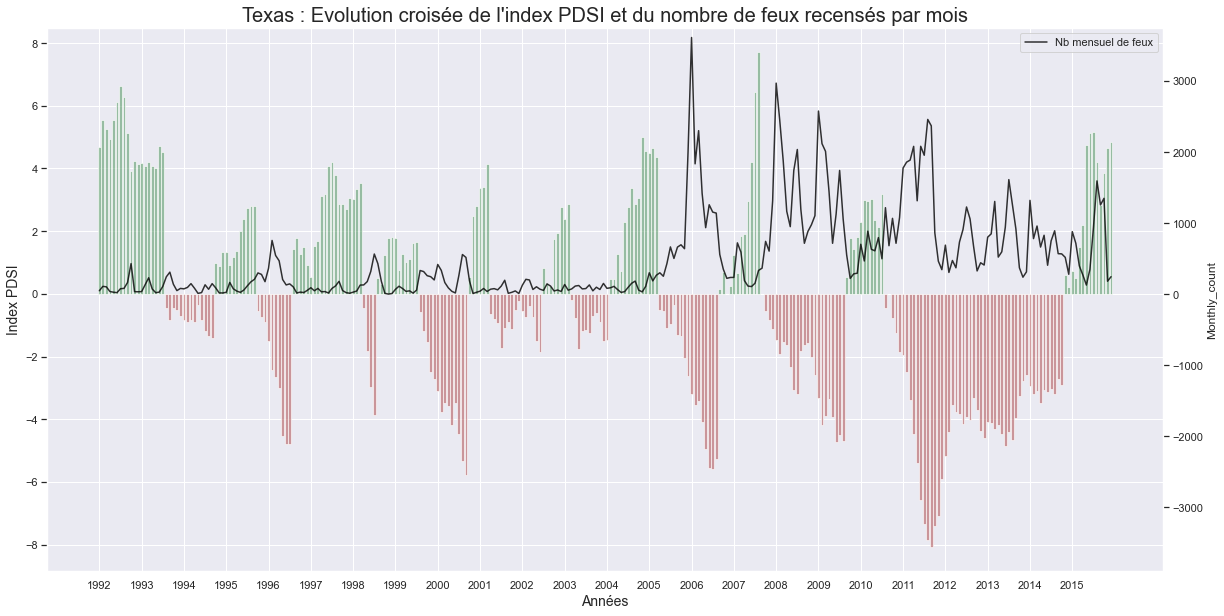

In [31]:
colors = ['g' if c >= 0 else 'r' for c in df_gpby['PDSI']]

fig, ax1 = plt.subplots(nrows = 1, figsize=(20,10))
sns.barplot(x='index', y='PDSI', palette = colors, ax=ax1, data = df_gpby, alpha = 0.6, label = 'Index PDSI')
ax2 = ax1.twinx()
sns.lineplot(data = df_gpby['Monthly_count'], ax=ax2, color = 'black', alpha = 0.8, label = 'Nb mensuel de feux')
ax1.set_xticklabels(df_gpby['Year'])
ax1.grid(True)
ax2.grid(None)
ax2.set_ylim(-3900,3750)
plt.locator_params(axis = 'x', nbins = 24)
ax1.set_ylabel("Index PDSI",fontsize=14)
ax1.set_xlabel("Années",fontsize=14)
plt.legend()
plt.title('Texas : Evolution croisée de l\'index PDSI et du nombre de feux recensés par mois', fontsize = 20);

> **Conclusion n°4 :** Cette visualisation superposée met en exergue :<br>
> 1. La corrélation négative entre l'index de Palmer et le nombre de feux, plus l'index prend des valeurs négatives fortes, plus la sécheresse est importante et plus il y a de risques d'observer des départs de feux<br>
> 2. La corrélation modérée entre ces deux indicateurs, malgré des valeurs d'index fortement négatives entre 2011 et 2015, on n'observe pas un nombre de feux aussi important qu'on aurait pu le penser